In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import math

!pip install dss_python
import dss

import time

import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams.update({
    'font.size': 8,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
})


In [2]:
WinterLoads = []
for i in range(1,101,1):
    with open(f"NandoLV/Winter_Load_CSVs/Winter_Load_Profiles_{i}.csv") as f:
        CustomerData = (f.read()).split("\n")[0:-1] #empty string at the last index of each list
        WinterLoads.append([float(x) for x in CustomerData])

SummerLoads = []
for i in range(1,101,1):
    with open(f"NandoLV/Summer_Load_CSVs/Customer_{i}.csv") as f:
        CustomerData = (f.read()).split("\n")[0:-1]
        SummerLoads.append([float(x) for x in CustomerData])

# Read PV data
PVLoads = []
for i in range(1,101,1):
    with open(f"NandoLV/Summer_PV_CSVs/Summer_PV_Profiles_{i}.csv") as f:
        CustomerData = (f.read()).split("\n")[0:-1]
        PVLoads.append([float(x) for x in CustomerData])

EVLoads = []
for i in range(1,101,1):
    with open(f"NandoLV/Winter_EV_CSVs/Winter_EV_Profiles_{i}.csv") as f:
        CustomerData = (f.read()).split("\n")[0:-1]
        EVLoads.append([2*float(x) for x in CustomerData])


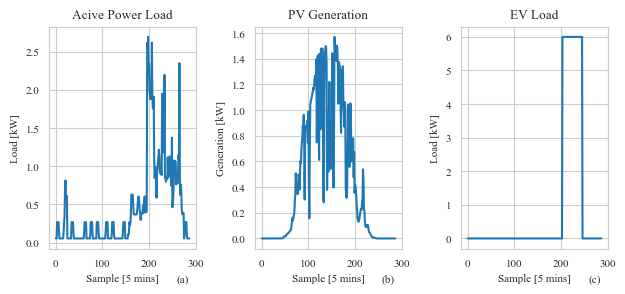

In [31]:
fig, ax = plt.subplots(1,3, figsize = (6.3,3))
ax[0].set_title("Acive Power Load")
ax[1].set_title("PV Generation")
ax[2].set_title("EV Load")



ax[0].set_ylabel("Load [kW]")
ax[1].set_ylabel("Generation [kW]")
ax[2].set_ylabel("Load [kW]")

sub_labels = ['(a)', '(b)', '(c)']
for i, label in enumerate(sub_labels):
    ax[i].set_xlabel("Sample [5 mins]")
    ax[i].text(0.95, -0.16, label, transform=ax[i].transAxes, horizontalalignment='right', verticalalignment='bottom')


for i in range(1):
    sns.lineplot(data = WinterLoads[i], ax = ax[0])
    sns.lineplot(data = PVLoads[i], ax = ax[1])
    sns.lineplot(data = EVLoads[i], ax = ax[2])
plt.tight_layout()
plt.savefig("Images/example_load.svg")

# Settings

In [4]:
LoadProfile = WinterLoads

# Select simulation length in days
SIM_LENGTH = 10

# LCT penetration percentages
PV_Penetration = 100
EV_Penetration = 100

# If True write results to Drive
WriteToDrive = True


# Furthest node in order of net, feed
Nodes_Longest = [53, 31, 38, 67, 175, 137, 110, 113, 23, 93, 58, 97, 35, 19, 38, 24, 16, 17, 83, 20, 22, 4, 18, 155, 30, 36, 15, 23, 23, 116, 42, 71, 56, 50, 186, 61, 12, 20, 41, 297, 85, 3, 20, 20, 66, 22, 14, 5, 14, 6, 11, 5, 15, 3, 17, 61, 86, 156, 67, 89, 46, 16, 2, 173, 64, 1, 60, 43, 1, 1, 77, 96, 97, 138, 22, 65, 53, 39, 73, 67, 58, 180, 8, 76, 106, 99, 210, 107, 54, 22, 41, 34, 28, 19, 28, 20, 44, 49, 107, 61, 53, 47, 1, 26, 57, 19, 1, 21, 21, 60, 18, 27, 26, 13, 45, 26, 26, 37, 110, 39, 1, 88, 43, 56, 79, 11, 18, 12]


# Init OpenDSS

In [5]:
dss_engine = dss.DSS
DSSText = dss_engine.Text
DSSCircuit = dss_engine.ActiveCircuit
DSSSolution = dss_engine.ActiveCircuit.Solution
ControlQueue = dss_engine.ActiveCircuit.CtrlQueue

# Function Definitions

In [6]:
def create_load_data(num_cust, num_days, data):
    customer_p, customer_q = [], []
    for _ in range(num_cust):
        cust_i_p,cust_i_q = [], []

        for _ in range(num_days):
            rand_int = random.randint(0,len(data)-1)
            cust_i_p.extend(data[rand_int])

            q = [i_load * math.tan(math.acos(random.uniform(0.9, 0.98))) for i_load in data[rand_int]]
            cust_i_q.extend(q)

        customer_p.append(cust_i_p)
        customer_q.append(cust_i_q)

    return customer_p, customer_q


def load_profile_allocation(New, icust, cust, iday, data_p, data_q, num_days):
    load_len = (len(data_p[0]))//num_days
    Zero_profile = [0]*load_len
    if New==1:
        DSSCircuit.LoadShapes.New(f"customer_profile_{icust}")
        DSSCircuit.LoadShapes.Npts = load_len
        DSSCircuit.LoadShapes.MinInterval = 5
        DSSCircuit.LoadShapes.UseActual = 1
        DSSCircuit.LoadShapes.Pmult = Zero_profile
        DSSCircuit.LoadShapes.Qmult = Zero_profile
        DSSCircuit.SetActiveElement(f"load.{cust}")
        DSSCircuit.ActiveElement.Properties("daily").Val = f"customer_profile_{icust}"
    else:
        #sets qmult and pmult to data[cust][day]
        DSSCircuit.LoadShapes.Name = f'customer_profile_{icust}'
        DSSCircuit.LoadShapes.Pmult = data_p[icust][iday*load_len: (iday+1)*load_len]
        DSSCircuit.LoadShapes.Qmult = data_q[icust][iday*load_len: (iday+1)*load_len]
        DSSCircuit.SetActiveElement(f"load.{cust}")
        DSSCircuit.ActiveElement.Properties('daily').Val = f'customer_profile_{icust}'


def Initiate_variable(Num_Cust):
    cols = len(LoadProfile[0])
    rows = Num_Cust
    kW_monitors = np.zeros((rows,cols))
    kvar_monitors = np.zeros((rows,cols))
    voltages_monitors = np.zeros((rows,cols))
    df_kw = pd.DataFrame()
    df_kvar = pd.DataFrame()
    df_volt = pd.DataFrame()
    load_profiles_all = []
    pv_profiles_all = []
    ev_profiles_all = []
    random_profiles_all = []
    rand_cust_PV = []
    rand_cust_EV = []
    reactive_profiles_all = []
    return  (kW_monitors, kvar_monitors, voltages_monitors, df_kw, df_kvar,
             df_volt, load_profiles_all, ev_profiles_all,pv_profiles_all, random_profiles_all, rand_cust_PV,rand_cust_EV,reactive_profiles_all)


def Monitors_data():
    for icust, cust in enumerate(Loadname):
            DSSCircuit.SetActiveElement('load.%s' %(cust))
            kW_monitors[icust][itime] = DSSCircuit.ActiveElement.Powers[0]
            kvar_monitors[icust][itime]= DSSCircuit.ActiveElement.Powers[1]
            bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
            DSSCircuit.SetActiveBus(bus_name)
            voltages_monitors[icust][itime] = DSSCircuit.ActiveBus.puVmagAngle[0]


In [7]:
def PV_allocation(loads, PV_custs, data_PV, num_days):
    for customer in PV_custs:
        cust_pv_daily = []
        for _ in range(num_days):
            cust_pv_daily.extend(random.choice(data_PV))
        loads[customer] = [x - y for x,y in zip(loads[customer], cust_pv_daily)]
    return loads

def EV_allocation(loads, EV_custs, data_EV, num_days):
    for customer in EV_custs:
        cust_ev_daily = []
        for _ in range(num_days):
            cust_ev_daily.extend(random.choice(data_EV))
        loads[customer] = [x + y for x,y in zip(loads[customer], cust_ev_daily)]
    return loads


# Simulation

In [8]:
StartDay = 0
start_time = time.time()
count = 0
for Network_Number in range(1,26+1):
    Feeder_Number = 0
    while True:
        Feeder_Number += 1

       
        DSSText.Command = 'Clear'
        DSSText.Command = 'Set DefaultBaseFrequency=50'
        DSSText.Command = 'New circuit.LVNet1circuit basekv=22.0 pu=1.00 angle=0 frequency=50 phases=3'
        try:
            DSSText.Command = f'Compile /Users/OMalleyAG/Documents/Python/NandoLV/LVNetworkModels/Network_{Network_Number}/Feeder_{Feeder_Number}/Master.txt'
        except:
            break
        count += 1
        print(f"Network {Network_Number}, Feeder {Feeder_Number}, Node of Intrest {Nodes_Longest[count-1]}")
        
        DSSText.Command = 'Set VoltageBases = [22.0, 0.400]'
        DSSText.Command = 'calcvoltagebases'

        Loadname = DSSCircuit.Loads.AllNames

        customer_p, customer_q = create_load_data(len(Loadname), SIM_LENGTH, LoadProfile)


        # Init all load profile allocations
        for icust, cust in enumerate(Loadname):
            load_profile_allocation(1, icust, cust, 0, customer_p, customer_q, num_days=SIM_LENGTH)


        # choose set of customers with EV and PV
        rand_cust_EV = random.sample(range(len(Loadname)), round(len(Loadname)*(EV_Penetration/100)))
        print("EV:", rand_cust_EV)
        rand_cust_PV = random.sample(range(len(Loadname)), round(len(Loadname)*(PV_Penetration/100)))
        print("PV:", rand_cust_PV)
        #allocate PV and EV loads
        customer_p = PV_allocation(customer_p, rand_cust_PV, PVLoads, SIM_LENGTH)
        customer_p = EV_allocation(customer_p, rand_cust_EV, EVLoads, SIM_LENGTH)
        Voltages_Daily, kW_Daily, kvar_Daily = [], [], []

        for iday in range(StartDay,StartDay+SIM_LENGTH):
            print("This is day: ",iday + 1)

            (kW_monitors, kvar_monitors, voltages_monitors, df_kw, df_kvar, df_volt,
            load_profiles_all, ev_profiles_all, pv_profiles_all, random_profiles_all, rand_cust_PV,rand_cust_EV,reactive_profiles_all) = Initiate_variable(len(Loadname))

            for icust, cust in enumerate(Loadname):
                load_profile_allocation(0, icust, cust, iday, customer_p, customer_q, num_days=SIM_LENGTH)


            DSSText.Command = 'Reset'
            DSSText.Command = 'Set Mode=daily  number=1 stepsize=5m'

            for itime in range(len(LoadProfile[0])):
                DSSSolution.Solve()
                Monitors_data()

            Voltages_Daily.append(voltages_monitors)
            kW_Daily.append(kW_monitors)
            kvar_Daily.append(kvar_monitors)

            if DSSSolution.Converged:
                print('The Solution Converged Successfully')
            else:
                print("The Solution Did Not Converge")

        #ignore Q
        #Dataset = np.concatenate((customer_p,customer_q)).T
        Dataset = np.array(customer_p).T

        Targets = []
        for i in range(SIM_LENGTH):
            for j in range(len(Voltages_Daily[0][0])):
                Targets.append(Voltages_Daily[i][Nodes_Longest[count-1]-1][j])

        if WriteToDrive:
            with open(f"/Users/OMalleyAG/Documents/Python/Simulation_Results_{PV_Penetration}/Loads_Network_{Network_Number}_Feeder_{Feeder_Number}.npy", 'wb') as f:
                np.save(f, Dataset)

            with open(f"/Users/OMalleyAG/Documents/Python/Simulation_Results_{PV_Penetration}/Targets_Network_{Network_Number}_Feeder_{Feeder_Number}.npy", "wb") as f:
                np.save(f, Targets)



end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed Time:", elapsed_time)

Network 1, Feeder 1, Node of Intrest 53
EV: [45, 52, 33, 12, 35, 13, 10, 20, 26, 19, 30, 1, 2, 25, 4, 37, 47, 44, 5, 18, 51, 31, 48, 32, 42, 7, 15, 29, 17, 21, 24, 36, 49, 3, 46, 8, 11, 14, 34, 23, 27, 41, 54, 50, 28, 39, 22, 40, 16, 53, 38, 6, 9, 43, 0]
PV: [5, 31, 43, 25, 27, 22, 35, 28, 4, 20, 37, 29, 14, 39, 12, 11, 16, 38, 34, 8, 3, 48, 18, 49, 36, 41, 53, 10, 52, 1, 9, 44, 24, 54, 6, 40, 17, 15, 30, 0, 46, 51, 33, 13, 47, 19, 23, 26, 42, 50, 21, 32, 2, 7, 45]
This is day:  1
The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 1

The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 2, Feeder 4, Node of Intrest 113
EV: [57, 40, 29, 64, 1, 31, 28, 80, 48, 11, 62, 39, 7, 70, 27, 77, 107, 22, 76, 3, 18, 91, 23, 2, 15, 111, 37, 100, 69, 50, 32, 96, 87, 97, 8, 6, 102, 88, 24, 85, 75, 104, 54, 74, 30, 112, 81, 14, 13, 9, 60, 12, 79, 59, 89, 82, 92, 51, 43, 95, 58, 68, 63, 49, 47, 35, 83, 113, 16, 52, 110, 0, 61, 53, 26, 55, 46, 34, 65, 41, 17, 99, 56, 4, 108, 109, 20, 19, 94, 86, 101, 84, 67, 72, 73, 103, 25, 42, 21, 45, 38, 10, 71, 33, 44, 114, 106, 36, 105, 90, 78,

The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 4, Feeder 1, Node of Intrest 24
EV: [14, 23, 16, 18, 7, 1, 3, 20, 11, 8, 9, 0, 21, 4, 6, 17, 13, 10, 12, 22, 5, 2, 15, 19]
PV: [22, 4, 2, 20, 19, 23, 13, 12, 10, 0, 5, 11, 18, 8, 7, 1, 15, 16, 9, 3, 14, 6, 17, 21]
This is day:  1
The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day: 

The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 5, Feeder 4, Node of Intrest 30
EV: [1, 19, 23, 15, 21, 4, 22, 8, 2, 0, 9, 7, 17, 13, 16, 25, 20, 3, 14, 18, 24, 12, 6, 5, 27, 29, 28, 10, 26, 11]
PV: [14, 12, 22, 3, 15, 11, 24, 5, 23, 8, 28, 4, 7, 16, 1, 25, 29, 2, 13, 10, 18, 27, 6, 21, 20, 9, 19, 0, 17, 26]
This is day:  1
The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
T

The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 7, Feeder 3, Node of Intrest 50
EV: [48, 1, 37, 27, 15, 38, 44, 4, 5, 12, 2, 8, 7, 3, 42, 40, 9, 41, 21, 30, 45, 14, 0, 13, 20, 49, 34, 29, 39, 31, 24, 26, 16, 25, 28, 11, 22, 6, 18, 46, 47, 32, 23, 19, 43, 33, 35, 17, 10, 36]
PV: [18, 11, 24, 5, 19, 0, 38, 31, 30, 10, 37, 22, 7, 29, 25, 13, 40, 49, 33, 42, 23, 46, 17, 43, 35, 26, 14, 2, 36, 32, 45, 16, 8, 21, 41, 28, 34, 6, 9, 1, 44, 12, 47, 15, 39, 3, 27, 20, 48, 4]
This is day:  1
The Solution Converged Successfully
This is day: 

The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 9, Feeder 1, Node of Intrest 85
EV: [66, 83, 54, 14, 76, 17, 34, 75, 31, 77, 10, 70, 53, 52, 3, 22, 15, 9, 25, 39, 46, 42, 47, 72, 67, 29, 40, 51, 57, 63, 74, 59, 50, 36, 73, 62, 4, 28, 58, 19, 33, 8, 2, 60, 35, 38, 68, 64, 13, 45, 78, 30, 37, 49, 71, 26, 23, 11, 80, 69, 61, 55, 12, 43, 18, 27, 56, 6, 32, 44, 65, 81, 79, 41, 1, 84, 82, 7, 21, 5, 16, 48, 20, 0, 24]
PV: [24, 40, 9, 36, 62, 48, 72, 1, 4, 76, 30, 66, 31, 39, 50, 20, 8, 81, 73, 60, 25, 23, 12, 34, 47, 45, 38, 6, 49, 11, 

The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 10, Feeder 5, Node of Intrest 11
EV: [2, 4, 10, 1, 5, 9, 7, 0, 6, 3, 8]
PV: [4, 10, 6, 0, 1, 8, 2, 5, 7, 9, 3]
This is day:  1
The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:

EV: [45, 79, 54, 11, 41, 27, 82, 14, 23, 52, 29, 25, 10, 28, 68, 18, 50, 51, 53, 34, 58, 57, 6, 12, 8, 3, 20, 21, 26, 15, 72, 56, 49, 80, 31, 59, 73, 4, 19, 67, 76, 36, 2, 46, 65, 38, 42, 43, 35, 13, 60, 75, 69, 63, 9, 37, 61, 64, 1, 5, 47, 32, 78, 44, 17, 55, 33, 77, 70, 48, 22, 24, 81, 66, 30, 40, 7, 74, 39, 16, 71, 0, 62]
PV: [41, 12, 27, 2, 72, 44, 50, 81, 42, 31, 40, 56, 79, 15, 39, 29, 0, 53, 47, 66, 49, 57, 80, 60, 43, 69, 78, 26, 18, 33, 74, 73, 22, 75, 11, 54, 32, 82, 24, 14, 71, 65, 6, 38, 17, 36, 28, 45, 1, 9, 13, 8, 10, 4, 23, 70, 35, 16, 34, 5, 59, 55, 61, 68, 63, 62, 3, 20, 64, 52, 76, 58, 30, 21, 48, 37, 7, 77, 25, 51, 67, 46, 19]
This is day:  1
The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Conve

The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 14, Feeder 3, Node of Intrest 60
EV: [40, 48, 10, 11, 55, 54, 34, 42, 3, 43, 4, 46, 15, 49, 52, 45, 57, 1, 35, 19, 56, 59, 17, 58, 2, 27, 9, 24, 51, 53, 7, 37, 22, 14, 33, 21, 30, 0, 18, 26, 16, 32, 29, 6, 25, 38, 13, 8, 44, 36, 50, 5, 12, 20, 47, 41, 28, 39, 31, 23]
PV: [13, 27, 30, 16, 0, 6, 20, 11, 28, 31, 25, 58, 32, 1, 7, 55, 48, 42, 18, 24, 29, 9, 57, 3, 37, 14, 47, 39, 41, 8, 44, 12, 49, 51, 21, 2, 54, 56, 4, 19, 50, 36, 34, 52, 53, 46, 43, 22, 33, 59, 35, 38, 40, 26, 17, 15,

The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 15, Feeder 4, Node of Intrest 138
EV: [0, 106, 69, 84, 115, 108, 132, 31, 33, 97, 60, 111, 114, 42, 95, 16, 87, 14, 125, 86, 30, 135, 68, 123, 71, 35, 25, 70, 6, 74, 9, 17, 73, 121, 92, 37, 120, 49, 66, 81, 90, 20, 118, 75, 96, 45, 65, 126, 52, 122, 59, 130, 3, 22, 136, 117, 7, 53, 19, 103, 4, 83, 10, 109, 40, 80, 133, 28, 94, 100, 64, 61, 34, 112, 127, 105, 63, 102, 78, 54, 129, 93, 1, 32, 107, 131, 137, 36, 89, 24, 44, 46, 119, 26, 91, 2, 29, 38, 72, 82, 85, 67, 77, 57, 51, 128, 7

The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 17, Feeder 1, Node of Intrest 180
EV: [154, 150, 96, 78, 72, 179, 183, 1, 103, 28, 121, 17, 153, 84, 5, 71, 51, 64, 134, 14, 57, 32, 126, 112, 185, 10, 118, 141, 82, 156, 158, 186, 119, 60, 108, 184, 87, 59, 181, 46, 110, 147, 115, 83, 123, 142, 99, 23, 132, 42, 50, 89, 52, 105, 169, 113, 63, 37, 19, 49, 39, 143, 168, 29, 122, 48, 159, 27, 34, 101, 13, 175, 2, 133, 69, 146, 45, 9, 136, 15, 3, 44, 165, 171, 56, 0, 152, 187, 55, 88, 94, 61, 65, 145, 137, 149, 8, 31, 163, 172, 80, 79, 

The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 17, Feeder 7, Node of Intrest 107
EV: [16, 22, 84, 35, 20, 55, 28, 65, 11, 18, 110, 109, 81, 14, 57, 86, 42, 90, 53, 60, 9, 66, 24, 114, 67, 106, 15, 51, 0, 49, 63, 71, 44, 105, 1, 10, 116, 52, 68, 33, 30, 104, 82, 23, 3, 96, 38, 54, 50, 39, 37, 111, 56, 83, 119, 78, 8, 27, 25, 79, 26, 102, 73, 61, 64, 88, 21, 99, 36, 108, 70, 97, 17, 45, 107, 92, 2, 118, 48, 59, 72, 115, 19, 101, 95, 77, 98, 87, 40, 47, 74, 29, 91, 5, 85, 112, 69, 34, 76, 89, 13, 103, 113, 75, 120, 41, 31, 117, 58,

The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 18, Feeder 9, Node of Intrest 44
EV: [20, 26, 18, 22, 32, 45, 12, 44, 6, 21, 16, 25, 30, 10, 43, 9, 11, 8, 38, 49, 1, 5, 7, 35, 19, 13, 2, 17, 36, 24, 31, 27, 0, 29, 46, 48, 41, 42, 39, 33, 4, 47, 40, 28, 15, 34, 3, 37, 14, 23]
PV: [27, 1, 46, 39, 32, 35, 49, 2, 30, 19, 13, 43, 9, 3, 38, 47, 7, 36, 0, 29, 16, 6, 44, 28, 34, 15, 8, 22, 42, 14, 12, 17, 10, 26, 40, 21, 24, 48, 33, 20, 18, 5, 11, 37, 31, 4, 45, 25, 23, 41]
This is day:  1
The Solution Converged Successfully
This is day:

The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 20, Feeder 3, Node of Intrest 57
EV: [32, 33, 10, 55, 13, 7, 0, 28, 16, 12, 24, 35, 4, 44, 2, 39, 25, 3, 50, 45, 58, 23, 54, 6, 36, 37, 27, 5, 9, 31, 1, 52, 18, 15, 11, 47, 48, 14, 51, 38, 34, 29, 46, 26, 53, 19, 22, 8, 56, 20, 40, 42, 30, 21, 57, 43, 41, 17, 49]
PV: [40, 11, 13, 3, 14, 53, 44, 0, 12, 41, 15, 28, 45, 32, 33, 54, 22, 18, 5, 36, 58, 24, 46, 2, 37, 48, 30, 19, 25, 23, 4, 27, 51, 49, 29, 39, 34, 47, 6, 10, 35, 21, 17, 31, 7, 43, 50, 16, 55, 9, 52, 57, 8, 1, 38, 26, 20, 56, 42]
This is day:  1
The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Succe

The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 22, Feeder 3, Node of Intrest 45
EV: [41, 4, 35, 18, 9, 42, 5, 23, 44, 3, 16, 29, 37, 21, 7, 36, 12, 20, 0, 26, 45, 33, 22, 43, 32, 30, 8, 27, 28, 38, 34, 24, 13, 2, 6, 10, 46, 47, 40, 39, 19, 1, 31, 17, 15, 25, 11, 14]
PV: [13, 7, 19, 37, 12, 47, 17, 21, 10, 44, 6, 5, 24, 8, 40, 4, 33, 43, 3, 25, 30, 2, 31, 38, 36, 16, 23, 29, 18, 20, 34, 15, 26, 32, 9, 11, 27, 35, 28, 39, 42, 46, 45, 22, 14, 1, 0, 41]
This is day:  1
The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4
The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solutio

The Solution Converged Successfully
This is day:  5
The Solution Converged Successfully
This is day:  6
The Solution Converged Successfully
This is day:  7
The Solution Converged Successfully
This is day:  8
The Solution Converged Successfully
This is day:  9
The Solution Converged Successfully
This is day:  10
The Solution Converged Successfully
Network 24, Feeder 1, Node of Intrest 56
EV: [2, 21, 11, 32, 10, 15, 19, 1, 29, 25, 38, 45, 3, 17, 49, 6, 12, 27, 40, 26, 51, 50, 22, 0, 16, 30, 31, 18, 4, 42, 20, 54, 14, 24, 37, 44, 35, 33, 7, 55, 8, 34, 41, 23, 28, 5, 46, 13, 47, 53, 48, 43, 36, 39, 9, 52]
PV: [22, 39, 12, 24, 27, 36, 44, 55, 14, 6, 21, 40, 1, 50, 52, 49, 35, 46, 32, 13, 3, 37, 2, 29, 45, 51, 17, 16, 4, 15, 38, 7, 10, 23, 33, 26, 48, 19, 47, 42, 41, 0, 31, 28, 11, 25, 54, 53, 34, 18, 9, 5, 43, 30, 8, 20]
This is day:  1
The Solution Converged Successfully
This is day:  2
The Solution Converged Successfully
This is day:  3
The Solution Converged Successfully
This is day:  4


In [9]:
len(np.array(customer_p).T)

2870

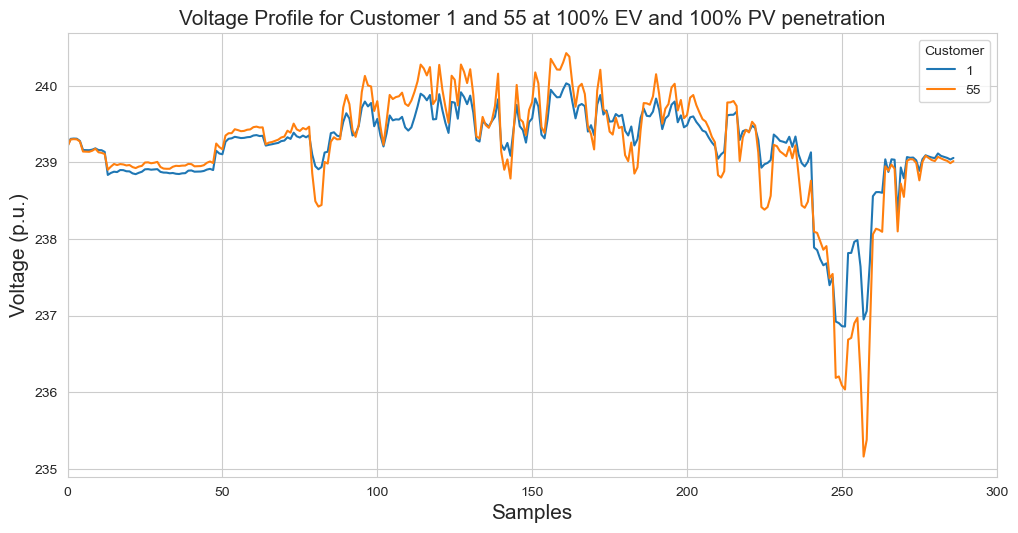

In [10]:
### Plotting Voltages###
fig, axes = plt.subplots(1,1, figsize = (10,5))
axes.set_xlim(0,300)
plt.tight_layout()
plt.xlabel("Samples", fontsize = 15)
plt.ylabel('Voltage (p.u.)', fontsize = 15)
plt.title(f'Voltage Profile for Customer 1 and {55} at {EV_Penetration}% EV and {PV_Penetration}% PV penetration', fontsize = 15)

sns.lineplot(data = 230*Voltages_Daily[0][0], label = "1")
sns.lineplot(data = 230*Voltages_Daily[0][-1], label = f"{55}")


plt.legend(title = "Customer")